In [1]:
import numpy as np
import pandas as pd

from numpy import mean, std, cov, sqrt, log, sum
from numpy.random import seed

from datetime import date, timedelta, datetime

from scipy.stats import pearsonr,spearmanr, boxcox
from scipy import stats

from random import sample

from apyori import apriori
from mlxtend.frequent_patterns import apriori

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib_venn import venn2
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

import matplotlib.style as style

from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm

from statsmodels.formula.api import ols


import warnings
warnings.filterwarnings('ignore')

import scripts as src

from IPython.display import HTML, display

# style.use('fivethirtyeight')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

rcParams['figure.figsize'] = (6, 3)

rand_state=1000

In [2]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import catboost as ctb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc

import tensorflow.keras
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

## Import Data

In [3]:
## import data
raw_beneficiary=pd.read_csv('data/Train_Beneficiarydata-1542865627584.csv')
raw_inpatient=pd.read_csv('data/Train_Inpatientdata-1542865627584.csv')
raw_outpatient=pd.read_csv('data/Train_Outpatientdata-1542865627584.csv')
raw_train=pd.read_csv('data/Train-1542865627584.csv')

## merge data
inpatient_beneficiary=pd.merge(raw_inpatient,raw_beneficiary,on='BeneID')
outpatient_beneficiary=pd.merge(raw_outpatient,raw_beneficiary,on='BeneID')

outpatient_beneficiary['Category']='Outpatient'
inpatient_beneficiary['Category']='Inpatient'

raw=pd.concat([outpatient_beneficiary, inpatient_beneficiary], axis = 0)
raw=pd.merge(raw,raw_train,on='Provider', how='left')

In [4]:
y = raw['PotentialFraud']
X = raw.drop(['PotentialFraud'], axis=1) # becareful inplace= False

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
df_train=pd.concat([X_train, y_train], axis=1)
df_test=pd.concat([X_test, y_test], axis=1)
print('train data size:',df_train.shape,
     '\ntrain data size:',df_test.shape,
     '\ntotal:',len(df_train)+len(df_test))

train data size: (446568, 56) 
train data size: (111643, 56) 
total: 558211


## Feature Engineering

In [5]:
def preprocessing(df_raw):
    ## Ages
    df_raw[['ClaimStartDt', 'ClaimEndDt', 'DischargeDt', 'AdmissionDt', 'DOB', 'DOD']]= \
            df_raw[['ClaimStartDt', 'ClaimEndDt', 'DischargeDt', 'AdmissionDt', 'DOB', 'DOD']].apply(pd.to_datetime, format='%Y-%m-%d')

    df_raw['IsDead']=np.where(df_raw['DOD'].isna(), 'No', 'Yes')

    df_raw['AdmissionDt']=df_raw['AdmissionDt'].fillna(df_raw['ClaimStartDt'])

    df_raw['Age']=round((pd.to_datetime(df_raw['AdmissionDt'])-pd.to_datetime(df_raw['DOB'])).dt.total_seconds() / (24 * 60 * 60 * 365),1)

    df_raw['Age_group'] = pd.cut(df_raw['Age'],
                         bins=[0,25, 35, 45,55,65,75,85,90,100,120],
                         labels=['<25','25-35','35-45','45-55','55-65','65-75','75-85','85-90','95-100','>100'],
                         right=False)

    df=df_raw[['Provider','Age']].groupby(['Provider'])['Age'].mean().reset_index().rename(columns={'Age':'AverageAge'})
    df_raw=pd.merge(df_raw, df, on='Provider', how='left')

    ## RenalDiseaseIndicator
    df_raw['RenalDiseaseIndicator']=np.where((df_raw['RenalDiseaseIndicator'])=='0', 0, 1)

    ## Gender 
    df_raw = df_raw.replace({'Gender': 2}, 'Female')
    df_raw = df_raw.replace({'Gender': 1}, 'Male')

    ## Chronic Features
    df_raw = df_raw.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                       'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                       'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                       'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)

    chronic_list=['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 
                  'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
                  'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
                  'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke','RenalDiseaseIndicator']

    # add mean of chronic condition numbers in claims by providers
    df_raw['Chronic_number']=df_raw[chronic_list].sum(axis=1)

    df=df_raw[chronic_list+['Provider','Chronic_number']].groupby(['Provider']).mean().reset_index()

    df_raw.drop(chronic_list+['Chronic_number'], axis=1, inplace=True)
    df_raw=pd.merge(df_raw, df, on='Provider', how='left')

    ## Treatment Duration
    df_raw['ClaimStartWeek']=df_raw['ClaimStartDt'].dt.week
    df_raw['ClaimStartYear']=df_raw['ClaimStartDt'].dt.year

    df_raw['DischargeDt']=df_raw['DischargeDt'].fillna(df_raw['AdmissionDt'])

    df_raw['TreatmentDuration']=(df_raw['DischargeDt']-df_raw['AdmissionDt']).astype('timedelta64[D]').astype('int', errors='ignore')
    
    ## Diagnosis and Procedure codes
    # fill in missing values
    df_raw.dropna(how='all', inplace=True)

    codelist=['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
           'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
           'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
           'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
           'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
           'ClmProcedureCode_5', 'ClmProcedureCode_6','ClmAdmitDiagnosisCode','DiagnosisGroupCode']

    amountlist=['DeductibleAmtPaid']

    for col in codelist:
        df_raw[col]=df_raw[col].fillna('0')

    for col in amountlist:
        df_raw[col]=df_raw[col].fillna(0)  

    def duplicate_claims(df, index, category, newcolname, threshold=0):
        df_dup=df[[category,index]].drop_duplicates() \
                .groupby([index]).count().reset_index() \
                .rename( columns={category:newcolname}).sort_values(by=newcolname, ascending=False)

        df_dup=pd.merge(df, df_dup, on=index, how='left')
        df_dup[newcolname]=df_dup[newcolname].fillna(0)
        if threshold!=0:        
            counts_total=df_dup[[category]].nunique()[0]
            df_dup['IsTop'+index+'By'+category]=np.where((df_dup[newcolname]/counts_total) \
                    >=threshold, 'Yes', 'No')
        return df_dup

    # Duplicate Codes
    basic_info=['BeneID', 'ClaimStartDt', 'Provider','PotentialFraud']
    df=df_raw[basic_info]
    duplicated = df.duplicated(keep=False)
    some_duplicates = df[duplicated].sort_values(by=df.columns.to_list())

    some_duplicates=pd.merge(some_duplicates.drop_duplicates(),
                             df_raw,
                             on=['BeneID', 'ClaimStartDt', 'Provider', 'PotentialFraud'], 
                             how='left')


    # Add DuplicateClaimCounts
    some_duplicates=duplicate_claims(some_duplicates, 'Provider', 'ClaimID', 'DuplicateClaimCounts', 0)
    df_raw=pd.merge(df_raw, some_duplicates[['Provider','DuplicateClaimCounts']].drop_duplicates(), on='Provider', how='left')
    df_raw['DuplicateClaimCounts']=df_raw['DuplicateClaimCounts'].fillna(0)

    def IsDuplicateCode(df, index, colcode, newcolname):
        df_dup_codes=df.groupby([index, colcode]).count()['ClaimID']
        df_dup_codes=df_dup_codes.sort_values(ascending=False).reset_index()
        df_dup_codes=df_dup_codes.replace('0',np.nan)
        df_dup_codes.dropna(how='any', inplace=True)
        df_dup_codes.rename( columns={'ClaimID':newcolname}, inplace=True)
        ProviderList=df_dup_codes[df_dup_codes[newcolname]>1][index].unique()
        return ProviderList

    # Add IsDuplicateClmAdmDiagCode
    ProviderList=IsDuplicateCode(some_duplicates, 'Provider', 'ClmAdmitDiagnosisCode', 'DuplicateAdmitDiagCode')
    df_raw['IsDuplicateClmAdmDiagCode']=np.where(df_raw['Provider'].isin(ProviderList),'Yes','No')

    # Add IsDuplicateClmAdmDiagCode
    ProviderList=IsDuplicateCode(some_duplicates, 'Provider', 'DiagnosisGroupCode', 'DuplicateDiagnosisGroupCode')
    df_raw['IsDuplicateDiagGrpCode']=np.where(df_raw['Provider'].isin(ProviderList),'Yes','No')

    # Most frequently used diagnosis codes codes
    def most_codes(df):
        df_codes=pd.DataFrame()
        for col in df.columns:
            df_codes[col]=df.groupby([col]).count().iloc[:,1].sort_values(ascending=False)  
        if df_codes.index.isin(['nan']).any():
            df_codes.drop(['nan'], inplace=True)   
        if df_codes.index.isin(['0']).any():
            df_codes.drop(['0'], inplace=True)   
        df_codes=df_codes.sum(axis=1).sort_values(ascending=False)
        return df_codes

    Diagnosiscodelist=['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
           'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
           'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
           'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10']
    Procedurecodelist=[
           'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
           'ClmProcedureCode_5', 'ClmProcedureCode_6']

    codelist=Diagnosiscodelist+Procedurecodelist

    df_diagnosis=df_raw[Diagnosiscodelist]
    df_procedure=df_raw[Procedurecodelist]
    diagnosiscodelist=most_codes(df_diagnosis).head(30).index.tolist()
    procedurecodelist=most_codes(df_procedure).head(15).index.tolist()

    df=pd.DataFrame()
    for c in diagnosiscodelist:
        l=df_diagnosis.isin([c]).sum(axis=1)
        df['Diag_'+c]=l
    df_raw=pd.concat([df_raw, df], axis=1)

    df1=df_raw[Diagnosiscodelist+['Provider']].groupby(['Provider']).mean().reset_index()

    df=pd.DataFrame()
    for c in procedurecodelist:
        l=df_diagnosis.isin([c]).sum(axis=1)
        df['Proc_'+str(c)]=l
    df_raw=pd.concat([df_raw, df], axis=1)
    df2=df_raw[Procedurecodelist+['Provider']].groupby(['Provider']).mean().reset_index()

    df_raw.drop(codelist, axis=1, inplace=True)
    df_raw=pd.merge(df_raw, df1, on='Provider', how='left')
    df_raw=pd.merge(df_raw, df2, on='Provider', how='left')

    ## Summary
    df_raw['AnnualReimbursementAmt']=df_raw['IPAnnualReimbursementAmt'] + df_raw['OPAnnualReimbursementAmt']
    df_raw['AnnualDeductibleAmt']=df_raw['IPAnnualDeductibleAmt'] + df_raw['OPAnnualDeductibleAmt']
    df_raw['TotalPayment']=df_raw['DeductibleAmtPaid']+df_raw['InscClaimAmtReimbursed']

    ## Provider Features
    physicians=pd.melt(df_raw[['BeneID', 'ClaimID', 'Provider', 'Category',
           'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'PotentialFraud']], 
            id_vars=['BeneID','ClaimID', 'Provider','PotentialFraud','Category'], 
            value_vars=df_raw[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']], 
            var_name='Type', 
            value_name='Physician').sort_values(by=['ClaimID','Type']).dropna(subset=['Physician'])

    # Add Patient Counts For Providers
    # the providers with patient counts over 900 or 0.006 are mostly suspective of frauds
    # So add IsTopProviderByPatients (0.005 used to hold more erros)
    df_raw=duplicate_claims(df_raw, 'Provider', 'BeneID', 'PatientCountsByProviders', 0.005)

    # Add Physician Counts For Providers
    df=duplicate_claims(physicians, 'Provider', 'Physician', 'PhysicianCountsByProviders', 0)
    df=df[['Provider','PhysicianCountsByProviders']].drop_duplicates()
    df_raw=pd.merge(df_raw, df, on='Provider', how='left')

    # Add Claim Counts For Providers
    # the providers with claim counts over 1300 or 0.002 of all claims are mostly suspective of frauds
    # so Add IsTopProviderByClaimCounts (0.001 used to hold more erros)
    df_raw=duplicate_claims(df_raw, 'Provider', 'ClaimID', 'ClaimCountsByProviders', 0.001)
    
    ## Time Series Terms
    df_raw['ClaimDayOfWeek']=df_raw['ClaimStartDt'].dt.weekday

    df_raw['Week_start']=df_raw['ClaimStartDt'] - df_raw['ClaimDayOfWeek'] * np.timedelta64(1, 'D')
    df_raw['Week_end']= df_raw['Week_start'] + timedelta(days=6)

    df_raw=pd.merge(df_raw, df_raw.groupby(['ClaimStartYear','ClaimStartWeek','Category'])['ClaimID'].count(), 
                   on=['ClaimStartYear','ClaimStartWeek','Category'], how='left')

    df_raw= df_raw.rename( columns={'ClaimID_x':'ClaimID',
                             'ClaimID_y':'WeeklyClaimCountsByCategory'})

    df_raw['LogWeeklyCounts']=np.log(df_raw['WeeklyClaimCountsByCategory'])

    def ts_terms(df, category):   

        ts_category=df[df['Category']==category]

        ts_features_stat=ts_category[['LogWeeklyCounts','ClaimStartYear','ClaimStartWeek']].drop_duplicates() \
            .sort_values(['ClaimStartYear','ClaimStartWeek'])

        ts_features_stat=ts_features_stat.set_index(['ClaimStartYear','ClaimStartWeek'])

        ## Add AutoRegressive Terms
        ts_features_stat['lag_1']=ts_features_stat['LogWeeklyCounts'].shift(1)
        ts_features_stat['lag_2']=ts_features_stat['LogWeeklyCounts'].shift(2)

        ## Add Moving Average Terms
        ts_features_stat['rolling_mean_1'] = ts_features_stat['LogWeeklyCounts'].rolling(window=1).mean()
        ts_features_stat['rolling_mean_2'] = ts_features_stat['LogWeeklyCounts'].rolling(window=2).mean()

        ## Add Rolling term for 12 weeks
        ts_features_stat['rolling_mean_12'] = ts_features_stat['LogWeeklyCounts'].rolling(window=12).mean()

        ## Add differencing Terms
        ts_features_stat['diff_1'] = ts_features_stat['LogWeeklyCounts'].diff()
        ts_features_stat['diff_2'] = ts_features_stat['LogWeeklyCounts'].diff().diff()

        ts_features_stat['Category']=category
        ts_features_stat=ts_features_stat.reset_index()
        ts_features_stat.fillna(ts_features_stat.mean(), inplace=True)

        return ts_features_stat

    ts_features=df_raw[['ClaimStartDt','Category','LogWeeklyCounts','ClaimStartYear','ClaimStartWeek']]

    # Add ts features for outpatient
    ts_features_outpatient=ts_terms(ts_features, 'Outpatient')
    # Add ts features for inpatient
    ts_features_inpatient=ts_terms(ts_features, 'Inpatient')

    ts_features_allpatients=pd.concat([ts_features_inpatient,ts_features_outpatient])
    ts_features=ts_features[['ClaimStartDt','Category','ClaimStartYear','ClaimStartWeek']]
    ts_features=pd.merge(ts_features, ts_features_allpatients, on=['ClaimStartYear', 'ClaimStartWeek', 'Category'], how='left')
    df_raw[['lag_1', 'lag_2', 
          'rolling_mean_1', 'rolling_mean_2', 'rolling_mean_12', 
          'diff_1', 'diff_2']]=ts_features[['lag_1', 'lag_2', 
          'rolling_mean_1', 'rolling_mean_2', 'rolling_mean_12', 
          'diff_1', 'diff_2']]
    
    ## calculate mean counts of each state, race, gender, age_group and county of claims for each provider
    def pivot_category(df, index, category):
        index_list=df[index].sort_values().unique().tolist()
        category_list=df[category].unique().tolist()

        df_counts=df[[index,category,'ClaimID']]
        df_counts=df_counts.groupby([index,category]).count().reset_index()

        df_out = pd.DataFrame([(i, s) for i in index_list for s in category_list], columns=[index,category])
        df_out=pd.merge(df_out,df_counts,on=[index,category],how='left')
        df_out.fillna(0,inplace=True) 
        df_out=df_out.pivot(index=index, columns=category, values='ClaimID'). \
                reset_index().add_prefix(category+'_').rename(columns={category+'_'+index:index})
        df_out=pd.merge(df, df_out, on=index, how='left' )
        return df_out

    df_raw=pivot_category(df_raw,'Provider','State')    
    df_raw=pivot_category(df_raw,'Provider','Race')    
    df_raw=pivot_category(df_raw,'Provider','Gender')    
    df_raw=pivot_category(df_raw,'Provider','Age_group')    
    df_raw=pivot_category(df_raw,'Provider','County')    
    df_raw=pivot_category(df_raw,'Provider','Category')
    df_raw=pivot_category(df_raw,'Provider','IsDead')
    
    ## drop useless columns
    droplist1=['ClaimStartDt', 'ClaimEndDt', 'DOB', 'DOD',
     'Race', 'State', 'County', 'Category', 'AdmissionDt', 'IsDead',
     'DischargeDt', 'Age', 'Age_group', 'ClaimStartWeek', 'ClaimStartYear',
     'ClaimDayOfWeek', 'Week_start', 'Week_end', 'WeeklyClaimCountsByCategory']

    droplist2=['BeneID', 'Provider', 'ClaimID', 
               'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 
               'ClmAdmitDiagnosisCode', 'Gender', 'DiagnosisGroupCode']
    df_raw.drop(droplist1+droplist2,axis=1,inplace=True)
    
    df_raw.fillna(0, inplace=True)
    
    return df_raw

In [6]:
train=preprocessing(df_train)
test=preprocessing(df_test)

# make train and test the same columns
strain=set(train.columns)
stest=set(test.columns)
l_train=list(strain.difference(stest))
l_test=list(stest.difference(strain))
test.drop(columns =l_test, inplace=True)
test[l_train]=0

train.to_csv('data/train_after_processing.csv')
test.to_csv('data/test_after_processing.csv')

In [7]:
# train=pd.read_csv('data/train_after_processing.csv')
# test=pd.read_csv('data/test_after_processing.csv')

In [8]:
## usful functions
def numeric_columns(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','datetime64[ns]']
    df_numeric = df.select_dtypes(include=numerics)
    return df_numeric.columns

def object_columns(df):
    objects = ['object']
    df_object = df.select_dtypes(include=objects)
    return df_object.columns

def cat_features(df, ls):
    for l in ls:
        df[l]=df[l].astype(str)
    return df

<h1 style="background-color:powderblue;">Modelling</h1>

In [9]:
pd.crosstab(train['PotentialFraud'],train['PotentialFraud'], normalize='all')*100

PotentialFraud,No,Yes
PotentialFraud,,
No,61.851722,0.000000
Yes,0.000000,38.148278


In [10]:
pd.crosstab(test['PotentialFraud'],test['PotentialFraud'], normalize='all')*100

PotentialFraud,No,Yes
PotentialFraud,,
No,61.987765,0.000000
Yes,0.000000,38.012235


In [11]:
object_columns(train).tolist()

['PotentialFraud',
 'IsDuplicateClmAdmDiagCode',
 'IsDuplicateDiagGrpCode',
 'IsTopProviderByBeneID',
 'IsTopProviderByClaimID']

In [12]:
category_columns=['PotentialFraud',
     'IsDuplicateClmAdmDiagCode',
     'IsDuplicateDiagGrpCode',
     'IsTopProviderByBeneID',
     'IsTopProviderByClaimID']
train_dummies = pd.get_dummies(train, columns=category_columns, sparse=True, drop_first=True)
train_yd = train_dummies['PotentialFraud_Yes']
train_Xd = train_dummies.drop('PotentialFraud_Yes', axis=1) # becareful inplace= False

sc = StandardScaler(with_mean=False)
train_Xd_sc = sc.fit_transform(train_Xd)

enc = OrdinalEncoder()
train[category_columns]= enc.fit_transform(train[category_columns])

train_y_ord = train['PotentialFraud']
train_X_ord = train.drop(['PotentialFraud'], axis=1) # becareful inplace= False

train_X_ord=train_X_ord.fillna(0)
train_Xd=train_Xd.fillna(0)

In [13]:
test_dummies = pd.get_dummies(test, columns=category_columns, sparse=True, drop_first=True)
test_yd = test_dummies['PotentialFraud_Yes']
test_Xd = test_dummies.drop('PotentialFraud_Yes', axis=1) # becareful inplace= False

sc = StandardScaler(with_mean=False)
test_Xd_sc = sc.fit_transform(test_Xd)

enc = OrdinalEncoder()
test[category_columns]= enc.fit_transform(test[category_columns])

test_y_ord = test['PotentialFraud']
test_X_ord = test.drop(['PotentialFraud'], axis=1) # becareful inplace= False

test_X_ord=test_X_ord.fillna(0)
test_Xd=test_Xd.fillna(0)

# train_Xd[train_Xd.isna().any(axis=1)]

In [14]:
print('train_X_ord shape:', train_X_ord.shape)
print('test_X_ord shape:', test_X_ord.shape)

print('train_Xd_sc shape:', train_Xd_sc.shape)
print('test_Xd_sc shape:', test_Xd_sc.shape)

train_X_ord shape: (446568, 472)
test_X_ord shape: (111643, 472)
train_Xd_sc shape: (446568, 472)
test_Xd_sc shape: (111643, 472)


In [15]:
# Fitting RF classifier to the Training set
RF_classifier = RandomForestClassifier(random_state=rand_state)
RF_classifier.fit(train_X_ord, train_y_ord)
# Predicting the Test set probabilities and classes
y_hat_RF       = RF_classifier.predict(test_X_ord)
y_hat_RF_probs = RF_classifier.predict_proba(test_X_ord)
print('accuracy = {}'.format(accuracy_score(test_y_ord, y_hat_RF)))
print('f1 = {}'.format(f1_score(test_y_ord, y_hat_RF)))

accuracy = 0.6259505745993927
f1 = 0.03230291514112249


In [16]:
# Fitting AdaBoost classifier to the Training set
AdB_classifier = AdaBoostClassifier(random_state=rand_state)
AdB_classifier.fit(train_X_ord, train_y_ord)
y_hat_AdB      = AdB_classifier.predict(test_X_ord)
y_hat_AdB_probs = AdB_classifier.predict_proba(test_X_ord)
print('accuracy = {}'.format(accuracy_score(test_y_ord, y_hat_AdB)))
print('f1 = {}'.format(f1_score(test_y_ord, y_hat_AdB)))

accuracy = 0.758793654774594
f1 = 0.6988178188366085


In [17]:
# Fitting Gradient Boosting classifier to the Training set
GBM_classifier = GradientBoostingClassifier(random_state=rand_state, learning_rate=0.1, max_depth=12)
GBM_classifier.fit(train_X_ord, train_y_ord)
y_hat_GBM      = GBM_classifier.predict(test_X_ord)
y_hat_GBM_probs = GBM_classifier.predict_proba(test_X_ord)
print('accuracy = {}'.format(accuracy_score(test_y_ord, y_hat_GBM)))
print('f1 = {}'.format(f1_score(test_y_ord, y_hat_GBM)))

accuracy = 0.6550164363193394
f1 = 0.2804834762465206


In [18]:
# Fitting XGBoost classifier to the Training set
XGB_classifier = XGBClassifier(random_state=rand_state, eta=0.1, max_depth=12)
XGB_classifier.fit(train_X_ord, train_y_ord)

y_hat_XGB      = XGB_classifier.predict(test_X_ord)
y_hat_XGB_probs = XGB_classifier.predict_proba(test_X_ord)
print('accuracy = {}'.format(accuracy_score(test_y_ord, y_hat_XGB)))
print('f1 = {}'.format(f1_score(test_y_ord, y_hat_XGB)))

accuracy = 0.6620656915346238
f1 = 0.19979638584881648


In [19]:
CBC_classifier = ctb.CatBoostClassifier(depth=10, random_state=rand_state)
CBC_classifier.fit(train_X_ord, train_y_ord)
y_hat_CBC      = CBC_classifier.predict(test_X_ord)
y_hat_CBC_probs = CBC_classifier.predict_proba(test_X_ord)
print('accuracy = {}'.format(accuracy_score(test_y_ord, y_hat_CBC)))
print('f1 = {}'.format(f1_score(test_y_ord, y_hat_CBC)))

Learning rate set to 0.139456
0:	learn: 0.4701297	total: 1.76s	remaining: 29m 15s
1:	learn: 0.3378295	total: 3.51s	remaining: 29m 11s
2:	learn: 0.2628132	total: 5.13s	remaining: 28m 25s
3:	learn: 0.2184582	total: 7.07s	remaining: 29m 21s
4:	learn: 0.1769526	total: 8.8s	remaining: 29m 11s
5:	learn: 0.1619940	total: 10.4s	remaining: 28m 38s
6:	learn: 0.1446417	total: 12s	remaining: 28m 23s
7:	learn: 0.1281439	total: 14.1s	remaining: 29m 12s
8:	learn: 0.1150257	total: 16s	remaining: 29m 25s
9:	learn: 0.1043329	total: 18.1s	remaining: 29m 49s
10:	learn: 0.1008932	total: 20.3s	remaining: 30m 22s
11:	learn: 0.0943779	total: 21.8s	remaining: 29m 58s
12:	learn: 0.0894726	total: 23.3s	remaining: 29m 31s
13:	learn: 0.0872044	total: 24.9s	remaining: 29m 10s
14:	learn: 0.0838409	total: 26.3s	remaining: 28m 47s
15:	learn: 0.0813390	total: 27.7s	remaining: 28m 21s
16:	learn: 0.0748533	total: 29.2s	remaining: 28m 10s
17:	learn: 0.0733638	total: 30.7s	remaining: 27m 57s
18:	learn: 0.0698044	total: 32.

153:	learn: 0.0029505	total: 3m 43s	remaining: 20m 30s
154:	learn: 0.0028462	total: 3m 45s	remaining: 20m 28s
155:	learn: 0.0027838	total: 3m 46s	remaining: 20m 27s
156:	learn: 0.0027362	total: 3m 48s	remaining: 20m 26s
157:	learn: 0.0027208	total: 3m 49s	remaining: 20m 25s
158:	learn: 0.0026961	total: 3m 51s	remaining: 20m 25s
159:	learn: 0.0026629	total: 3m 53s	remaining: 20m 24s
160:	learn: 0.0026008	total: 3m 54s	remaining: 20m 23s
161:	learn: 0.0025710	total: 3m 56s	remaining: 20m 22s
162:	learn: 0.0025453	total: 3m 57s	remaining: 20m 20s
163:	learn: 0.0024845	total: 3m 59s	remaining: 20m 19s
164:	learn: 0.0024012	total: 4m	remaining: 20m 18s
165:	learn: 0.0024012	total: 4m 2s	remaining: 20m 16s
166:	learn: 0.0023903	total: 4m 3s	remaining: 20m 14s
167:	learn: 0.0023506	total: 4m 4s	remaining: 20m 12s
168:	learn: 0.0023367	total: 4m 6s	remaining: 20m 10s
169:	learn: 0.0023366	total: 4m 7s	remaining: 20m 8s
170:	learn: 0.0023075	total: 4m 9s	remaining: 20m 7s
171:	learn: 0.0022775	

304:	learn: 0.0012205	total: 7m 49s	remaining: 17m 49s
305:	learn: 0.0012205	total: 7m 51s	remaining: 17m 48s
306:	learn: 0.0012205	total: 7m 52s	remaining: 17m 46s
307:	learn: 0.0012205	total: 7m 54s	remaining: 17m 45s
308:	learn: 0.0012205	total: 7m 55s	remaining: 17m 44s
309:	learn: 0.0012205	total: 7m 57s	remaining: 17m 42s
310:	learn: 0.0012205	total: 7m 58s	remaining: 17m 41s
311:	learn: 0.0012205	total: 8m	remaining: 17m 39s
312:	learn: 0.0012205	total: 8m 2s	remaining: 17m 38s
313:	learn: 0.0012205	total: 8m 3s	remaining: 17m 36s
314:	learn: 0.0012205	total: 8m 5s	remaining: 17m 35s
315:	learn: 0.0012205	total: 8m 6s	remaining: 17m 33s
316:	learn: 0.0012205	total: 8m 8s	remaining: 17m 31s
317:	learn: 0.0012205	total: 8m 9s	remaining: 17m 30s
318:	learn: 0.0012205	total: 8m 11s	remaining: 17m 28s
319:	learn: 0.0012205	total: 8m 12s	remaining: 17m 26s
320:	learn: 0.0012205	total: 8m 14s	remaining: 17m 25s
321:	learn: 0.0012205	total: 8m 15s	remaining: 17m 23s
322:	learn: 0.001220

454:	learn: 0.0010790	total: 12m 8s	remaining: 14m 32s
455:	learn: 0.0010790	total: 12m 9s	remaining: 14m 30s
456:	learn: 0.0010791	total: 12m 11s	remaining: 14m 29s
457:	learn: 0.0010791	total: 12m 13s	remaining: 14m 27s
458:	learn: 0.0010790	total: 12m 15s	remaining: 14m 26s
459:	learn: 0.0010790	total: 12m 16s	remaining: 14m 24s
460:	learn: 0.0010790	total: 12m 18s	remaining: 14m 23s
461:	learn: 0.0010790	total: 12m 19s	remaining: 14m 21s
462:	learn: 0.0010790	total: 12m 21s	remaining: 14m 19s
463:	learn: 0.0010790	total: 12m 22s	remaining: 14m 18s
464:	learn: 0.0010790	total: 12m 24s	remaining: 14m 16s
465:	learn: 0.0010790	total: 12m 25s	remaining: 14m 14s
466:	learn: 0.0010790	total: 12m 27s	remaining: 14m 13s
467:	learn: 0.0010790	total: 12m 29s	remaining: 14m 12s
468:	learn: 0.0010790	total: 12m 31s	remaining: 14m 10s
469:	learn: 0.0010790	total: 12m 33s	remaining: 14m 9s
470:	learn: 0.0010790	total: 12m 35s	remaining: 14m 8s
471:	learn: 0.0010790	total: 12m 36s	remaining: 14m 

602:	learn: 0.0010785	total: 16m 19s	remaining: 10m 44s
603:	learn: 0.0010784	total: 16m 20s	remaining: 10m 43s
604:	learn: 0.0010784	total: 16m 22s	remaining: 10m 41s
605:	learn: 0.0010785	total: 16m 24s	remaining: 10m 39s
606:	learn: 0.0010784	total: 16m 26s	remaining: 10m 38s
607:	learn: 0.0010784	total: 16m 27s	remaining: 10m 36s
608:	learn: 0.0010784	total: 16m 29s	remaining: 10m 35s
609:	learn: 0.0010784	total: 16m 30s	remaining: 10m 33s
610:	learn: 0.0010784	total: 16m 32s	remaining: 10m 31s
611:	learn: 0.0010784	total: 16m 34s	remaining: 10m 30s
612:	learn: 0.0010784	total: 16m 35s	remaining: 10m 28s
613:	learn: 0.0010784	total: 16m 37s	remaining: 10m 26s
614:	learn: 0.0010784	total: 16m 38s	remaining: 10m 25s
615:	learn: 0.0010784	total: 16m 40s	remaining: 10m 23s
616:	learn: 0.0010783	total: 16m 41s	remaining: 10m 21s
617:	learn: 0.0010783	total: 16m 43s	remaining: 10m 20s
618:	learn: 0.0010783	total: 16m 44s	remaining: 10m 18s
619:	learn: 0.0010784	total: 16m 45s	remaining: 

752:	learn: 0.0010782	total: 20m 14s	remaining: 6m 38s
753:	learn: 0.0010782	total: 20m 16s	remaining: 6m 36s
754:	learn: 0.0010782	total: 20m 17s	remaining: 6m 35s
755:	learn: 0.0010782	total: 20m 19s	remaining: 6m 33s
756:	learn: 0.0010782	total: 20m 20s	remaining: 6m 31s
757:	learn: 0.0010782	total: 20m 21s	remaining: 6m 30s
758:	learn: 0.0010782	total: 20m 23s	remaining: 6m 28s
759:	learn: 0.0010782	total: 20m 24s	remaining: 6m 26s
760:	learn: 0.0010782	total: 20m 26s	remaining: 6m 25s
761:	learn: 0.0010782	total: 20m 27s	remaining: 6m 23s
762:	learn: 0.0010782	total: 20m 29s	remaining: 6m 21s
763:	learn: 0.0010782	total: 20m 30s	remaining: 6m 20s
764:	learn: 0.0010782	total: 20m 32s	remaining: 6m 18s
765:	learn: 0.0010782	total: 20m 33s	remaining: 6m 16s
766:	learn: 0.0010782	total: 20m 35s	remaining: 6m 15s
767:	learn: 0.0010782	total: 20m 36s	remaining: 6m 13s
768:	learn: 0.0010782	total: 20m 38s	remaining: 6m 11s
769:	learn: 0.0010782	total: 20m 39s	remaining: 6m 10s
770:	learn

903:	learn: 0.0010779	total: 24m 4s	remaining: 2m 33s
904:	learn: 0.0010779	total: 24m 6s	remaining: 2m 31s
905:	learn: 0.0010779	total: 24m 7s	remaining: 2m 30s
906:	learn: 0.0010779	total: 24m 9s	remaining: 2m 28s
907:	learn: 0.0010779	total: 24m 10s	remaining: 2m 27s
908:	learn: 0.0010779	total: 24m 12s	remaining: 2m 25s
909:	learn: 0.0010779	total: 24m 13s	remaining: 2m 23s
910:	learn: 0.0010779	total: 24m 15s	remaining: 2m 22s
911:	learn: 0.0010779	total: 24m 16s	remaining: 2m 20s
912:	learn: 0.0010779	total: 24m 17s	remaining: 2m 18s
913:	learn: 0.0010779	total: 24m 19s	remaining: 2m 17s
914:	learn: 0.0010779	total: 24m 20s	remaining: 2m 15s
915:	learn: 0.0010779	total: 24m 22s	remaining: 2m 14s
916:	learn: 0.0010779	total: 24m 23s	remaining: 2m 12s
917:	learn: 0.0010779	total: 24m 25s	remaining: 2m 10s
918:	learn: 0.0010779	total: 24m 26s	remaining: 2m 9s
919:	learn: 0.0010779	total: 24m 28s	remaining: 2m 7s
920:	learn: 0.0010779	total: 24m 30s	remaining: 2m 6s
921:	learn: 0.001

In [20]:
LGB_classifier = lgb.LGBMClassifier()
LGB_classifier.fit(train_X_ord, train_y_ord)
y_hat_LGB     = LGB_classifier.predict(test_X_ord)
y_hat_LGB_probs = LGB_classifier.predict_proba(test_X_ord)
print('accuracy = {}'.format(accuracy_score(test_y_ord, y_hat_LGB)))
print('f1 = {}'.format(f1_score(test_y_ord, y_hat_LGB)))

accuracy = 0.6623971050580869
f1 = 0.2022562279086503


In [21]:
Logistic_classifier = LogisticRegression(random_state=rand_state)
Logistic_classifier.fit(train_Xd_sc, train_yd)
yd_hat_Logistic      = Logistic_classifier.predict(test_Xd_sc)
yd_hat_Logistic_probs = Logistic_classifier.predict_proba(test_Xd_sc)
print('accuracy = {}'.format(accuracy_score(test_yd, yd_hat_Logistic)))
print('f1 = {}'.format(f1_score(test_yd, yd_hat_Logistic)))

accuracy = 0.703098268588268
f1 = 0.412089178978734


In [22]:
Lasso_classifier = LogisticRegression(penalty="l1", solver="liblinear", random_state=rand_state)
Lasso_classifier.fit(train_Xd_sc, train_yd)
yd_hat_Lasso      = Lasso_classifier.predict(test_Xd_sc)
yd_hat_Lasso_probs = Lasso_classifier.predict_proba(test_Xd_sc)
print('accuracy = {}'.format(accuracy_score(test_yd, yd_hat_Lasso)))
print('f1 = {}'.format(f1_score(test_yd, yd_hat_Lasso)))

accuracy = 0.6331879293820482
f1 = 0.10047006106400737


In [23]:
Ridge_classifier = LogisticRegression(penalty='l2', solver='liblinear', random_state=rand_state)
Ridge_classifier.fit(train_Xd_sc, train_yd)
yd_hat_Ridge      = Ridge_classifier.predict(test_Xd_sc)
yd_hat_Ridge_probs = Ridge_classifier.predict_proba(test_Xd_sc) 
print('accuracy = {}'.format(accuracy_score(test_yd, yd_hat_Ridge)))
print('f1 = {}'.format(f1_score(test_yd, yd_hat_Ridge)))

accuracy = 0.6323817883790296
f1 = 0.08286033519553071


In [24]:
ElasticNet_classifier = LogisticRegression(penalty='elasticnet', solver='saga',l1_ratio=0.5, random_state=rand_state)
ElasticNet_classifier.fit(train_Xd_sc, train_yd)
yd_hat_ElasticNet      = ElasticNet_classifier.predict(test_Xd_sc)
yd_hat_ElasticNet_probs = ElasticNet_classifier.predict_proba(test_Xd_sc)
print('accuracy = {}'.format(accuracy_score(test_yd, yd_hat_ElasticNet)))
print('f1 = {}'.format(f1_score(test_yd, yd_hat_ElasticNet)))

accuracy = 0.7019069713282516
f1 = 0.43389807443695994


In [37]:
KNN_classifier = KNeighborsClassifier(n_neighbors=5)
KNN_classifier.fit(train_Xd_sc, train_yd)
yd_hat_KNN      = KNN_classifier.predict(test_Xd_sc)
yd_hat_KNN_probs = KNN_classifier.predict_proba(test_Xd_sc)
print('accuracy = {}'.format(accuracy_score(test_yd, yd_hat_KNN)))
print('f1 = {}'.format(f1_score(test_yd, yd_hat_KNN)))

accuracy = 0.6586351137106671
f1 = 0.33517662450937635


In [38]:
# Classification neural network

seed(rand_state)
tensorflow.random.set_seed(rand_state)
Neural_classifier = Sequential()
Neural_classifier.add(Dense(100, input_dim=train_Xd_sc.shape[1], activation='relu',
                kernel_initializer='random_normal'))
Neural_classifier.add(Dense(50,activation='relu',kernel_initializer='random_normal'))
Neural_classifier.add(Dense(25,activation='relu',kernel_initializer='random_normal'))
Neural_classifier.add(Dense(1,activation='sigmoid',kernel_initializer='random_normal'))
Neural_classifier.compile(loss='binary_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, 
    patience=5, verbose=1, mode='auto', restore_best_weights=True)

Neural_classifier.fit(train_Xd_sc,train_yd,validation_data=(test_Xd_sc,test_yd),
          callbacks=[monitor],verbose=2,epochs=30)

yd_hat_Neural = np.round(Neural_classifier.predict(test_Xd_sc))
yd_hat_Neural_probs = Neural_classifier.predict(test_Xd_sc)
print('accuracy = {}'.format(accuracy_score(test_yd, yd_hat_Neural)))
print('f1 = {}'.format(f1_score(test_yd, yd_hat_Neural)))

Epoch 1/30
13956/13956 - 52s - loss: 0.0778 - accuracy: 0.9700 - val_loss: 13.6453 - val_accuracy: 0.4536 - 52s/epoch - 4ms/step
Epoch 2/30
13956/13956 - 49s - loss: 0.0358 - accuracy: 0.9867 - val_loss: 11.6725 - val_accuracy: 0.6053 - 49s/epoch - 4ms/step
Epoch 3/30
13956/13956 - 35s - loss: 0.0247 - accuracy: 0.9914 - val_loss: 16.7652 - val_accuracy: 0.4257 - 35s/epoch - 3ms/step
Epoch 4/30
13956/13956 - 41s - loss: 0.0196 - accuracy: 0.9935 - val_loss: 20.0169 - val_accuracy: 0.5016 - 41s/epoch - 3ms/step
Epoch 5/30
13956/13956 - 37s - loss: 0.0162 - accuracy: 0.9947 - val_loss: 25.4930 - val_accuracy: 0.4708 - 37s/epoch - 3ms/step
Epoch 6/30
13956/13956 - 36s - loss: 0.0138 - accuracy: 0.9955 - val_loss: 20.6289 - val_accuracy: 0.5386 - 36s/epoch - 3ms/step
Epoch 7/30
Restoring model weights from the end of the best epoch: 2.
13956/13956 - 36s - loss: 0.0119 - accuracy: 0.9959 - val_loss: 21.1486 - val_accuracy: 0.5452 - 36s/epoch - 3ms/step
Epoch 7: early stopping
3489/3489 [===

In [39]:
def blended_predict(train_or_test):
#     if train_or_test=='train':
#         return ((0.5 * CBC_classifier.predict(train_X_ord)) + \
#                 (0.3 * XGB_classifier.predict(train_X_ord)) + \
#                 (0.1 * RF_classifier.predict(train_X_ord)) + \
#                 (0.1 * GBM_classifier.predict(train_X_ord)) )
#     else:
#         return ((0.5 * CBC_classifier.predict(test_X_ord)) + \
#                 (0.3 * XGB_classifier.predict(test_X_ord)) + \
#                 (0.1 * RF_classifier.predict(test_X_ord)) + \
#                 (0.1 * GBM_classifier.predict(test_X_ord)) )
    if train_or_test=='train':
        return ((0.5 * AdB_classifier.predict(train_X_ord)) + \
                (0.3 * Logistic_classifier.predict(train_Xd_sc)) + \
                (0.1 * ElasticNet_classifier.predict(train_Xd_sc)) + \
                (0.1 * CBC_classifier.predict(train_X_ord)) )
    else:
        return ((0.5 * AdB_classifier.predict(test_X_ord)) + \
                (0.3 * Logistic_classifier.predict(test_Xd_sc)) + \
                (0.1 * ElasticNet_classifier.predict(test_Xd_sc)) + \
                (0.1 * CBC_classifier.predict(test_X_ord)) )

def score_list(df, regr,  y_test=None, y_hat_test=None):
    if regr=='Blended Model':
        y_hat_blended_train=blended_predict('train')
        y_hat_blended_test=blended_predict('test')
        
        accuracy=accuracy_score(y_test, np.round(y_hat_blended_test))
        f1=f1_score(y_test, np.round(y_hat_blended_test))
        precision=precision_score(y_test, np.round(y_hat_blended_test), average='binary')
        recall=recall_score(y_test, np.round(y_hat_blended_test), average='binary')
    else:
        accuracy=accuracy_score(y_test, y_hat_test)
        f1=f1_score(y_test, y_hat_test)
        precision=precision_score(y_test, y_hat_test, average='binary')
        recall=recall_score(y_test, y_hat_test, average='binary')    


    df[regr]=[accuracy, f1, precision, recall]
    return df 

df=pd.DataFrame()              
    
# df['Scores']=['Train Score', 'Test Score', 'Train MSE', 'Test MSE', 'Train RMSE', 'Test RMSE']
df=score_list(df, 'Logistic Regression',  test_yd, yd_hat_Logistic)
df=score_list(df, 'Lasso',  test_yd, yd_hat_Lasso)
df=score_list(df, 'Ridge', test_yd, yd_hat_Ridge)
df=score_list(df, 'ElasticNet', test_yd, yd_hat_ElasticNet)
df=score_list(df, 'KNN', test_yd, yd_hat_KNN)
df=score_list(df, 'Random Forest', test_y_ord, y_hat_RF)
df=score_list(df, 'GBM', test_y_ord, y_hat_GBM)
df=score_list(df, 'ADA', test_y_ord, y_hat_AdB)
df=score_list(df, 'XGBoost', test_y_ord, y_hat_XGB)
df=score_list(df, 'Cat Boost', test_y_ord, y_hat_CBC)
df=score_list(df, 'LightGBM', test_y_ord, y_hat_LGB)
df=score_list(df, 'Neural Network', test_yd, yd_hat_Neural)
df=score_list(df, regr='Blended Model', y_test=test_y_ord)

df=df.transpose()
df.columns=['Accuracy', 'F1', 'Precision', 'Recall']
df.sort_values(by='Accuracy', ascending=False)

,Accuracy,F1,Precision,Recall
ADA,0.758794,0.698818,0.665084,0.736156
Blended Model,0.743244,0.516276,0.909399,0.360455
Logistic Regression,0.703098,0.412089,0.833178,0.273741
ElasticNet,0.701907,0.433898,0.780061,0.300533
Cat Boost,0.698396,0.344444,0.991037,0.208445
LightGBM,0.662397,0.202256,0.993554,0.112588
XGBoost,0.662066,0.199796,1.000000,0.110985
KNN,0.658635,0.335177,0.645328,0.226377
GBM,0.655016,0.280483,0.676855,0.176893
Lasso,0.633188,0.100470,0.740609,0.053890


In [40]:
features = list(X_train.columns)

RF_importance  = RF_classifier.feature_importances_
AdB_importance = AdB_classifier.feature_importances_
GBM_importance = GBM_classifier.feature_importances_
XGB_importance = XGB_classifier.feature_importances_
CBC_importance = CBC_classifier.feature_importances_
LGB_importance = LGB_classifier.feature_importances_
Logistic_importance = Logistic_classifier.coef_
Lasso_importance= Lasso_classifier.coef_
Ridge_importance= Ridge_classifier.coef_
ElasticNet_importance= ElasticNet_classifier.coef_

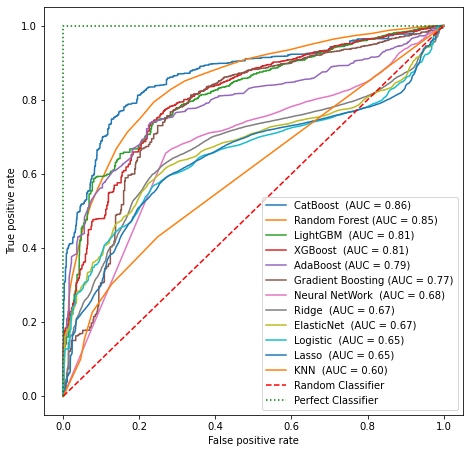

In [41]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))

fpr1, tpr1, thresholds = roc_curve(test_y_ord, y_hat_RF_probs[:, 1], pos_label=1)
fpr2, tpr2, thresholds = roc_curve(test_y_ord, y_hat_AdB_probs[:, 1], pos_label=1)
fpr3, tpr3, thresholds = roc_curve(test_y_ord, y_hat_GBM_probs[:, 1], pos_label=1)
fpr4, tpr4, thresholds = roc_curve(test_y_ord, y_hat_XGB_probs[:, 1], pos_label=1)
fpr5, tpr5, thresholds = roc_curve(test_y_ord, y_hat_CBC_probs[:, 1], pos_label=1)
fpr6, tpr6, thresholds = roc_curve(test_yd, yd_hat_Logistic_probs[:, 1], pos_label=1)
fpr7, tpr7, thresholds = roc_curve(test_yd, yd_hat_Lasso_probs[:, 1], pos_label=1)
fpr8, tpr8, thresholds = roc_curve(test_yd, yd_hat_Ridge_probs[:, 1], pos_label=1)
fpr9, tpr9, thresholds = roc_curve(test_yd, yd_hat_ElasticNet_probs[:, 1], pos_label=1)
fpr10, tpr10, thresholds = roc_curve(test_yd, yd_hat_KNN_probs[:, 1], pos_label=1)
fpr11, tpr11, thresholds = roc_curve(test_yd, yd_hat_Neural_probs, pos_label=1)
fpr12, tpr12, thresholds = roc_curve(test_y_ord, y_hat_LGB_probs[:, 1], pos_label=1)

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)
roc_auc6 = auc(fpr6, tpr6)
roc_auc7 = auc(fpr7, tpr7)
roc_auc8 = auc(fpr8, tpr8)
roc_auc9 = auc(fpr9, tpr9)
roc_auc10 = auc(fpr10, tpr10)
roc_auc11 = auc(fpr11, tpr11)
roc_auc12 = auc(fpr12, tpr12)

# auc = round(metrics.roc_auc_score(y_test, y_pred), 4)

plt.plot(fpr5, tpr5, label='CatBoost  (AUC = %0.2f)' % (roc_auc5))
plt.plot(fpr1, tpr1, label='Random Forest (AUC = %0.2f)' % (roc_auc1))
plt.plot(fpr12, tpr12, label='LightGBM  (AUC = %0.2f)' % (roc_auc12))
plt.plot(fpr4, tpr4, label='XGBoost  (AUC = %0.2f)' % (roc_auc4))
plt.plot(fpr2, tpr2, label='AdaBoost (AUC = %0.2f)' % (roc_auc2))
plt.plot(fpr3, tpr3, label='Gradient Boosting (AUC = %0.2f)' % (roc_auc3))
plt.plot(fpr11, tpr11, label='Neural NetWork  (AUC = %0.2f)' % (roc_auc11))
plt.plot(fpr8, tpr8, label='Ridge  (AUC = %0.2f)' % (roc_auc8))
plt.plot(fpr9, tpr9, label='ElasticNet  (AUC = %0.2f)' % (roc_auc9))
plt.plot(fpr6, tpr6, label='Logistic  (AUC = %0.2f)' % (roc_auc6))
plt.plot(fpr7, tpr7, label='Lasso  (AUC = %0.2f)' % (roc_auc7))
plt.plot(fpr10, tpr10, label='KNN  (AUC = %0.2f)' % (roc_auc10))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()

In [42]:
Logistic_importance[0,:].shape

(472,)

In [43]:
FIM = pd.DataFrame({'Features': train_X_ord.columns 
                   , 'CBC_Feature_importance':CBC_importance
                   , 'GBM_Feature_importance':GBM_importance
                   , 'XGB_Feature_importance':XGB_importance
                   , 'RF_Feature_importance':RF_importance
                   , 'LGB_Feature_importance':LGB_importance
                   , 'AdB_Feature_importance':AdB_importance
                   , 'Logistic_Feature_importance':Logistic_importance[0,:]
                   , 'Ridge_Feature_importance':Ridge_importance[0,:]
                   , 'Lasso_Feature_importance':Lasso_importance[0,:]
                   , 'ElasticNet_Feature_importance':ElasticNet_importance[0,:]})
FIM = FIM.sort_values(by=['AdB_Feature_importance'], ascending=False )
display(FIM[['Features',
             'AdB_Feature_importance',
             'Logistic_Feature_importance',
             'ElasticNet_Feature_importance',
             'CBC_Feature_importance']].head(50))

,Features,AdB_Feature_importance,Logistic_Feature_importance,ElasticNet_Feature_importance,CBC_Feature_importance
468,Category_Inpatient,0.16,-0.356299,-0.204847,14.868701
75,PatientCountsByProviders,0.06,0.463875,0.330193,1.609636
147,Age_group_35-45,0.06,0.306670,0.226419,1.102827
470,IsDead_No,0.04,3.278074,1.901753,0.903681
144,Gender_Female,0.04,0.460791,0.338562,1.204437
320,County_720,0.02,-0.192478,-0.114441,0.255204
118,State_31,0.02,0.003755,0.006414,0.354690
192,County_210,0.02,0.123385,0.126246,0.232571
367,County_830,0.02,-0.058742,-0.037662,0.000000
149,Age_group_55-65,0.02,0.818760,0.515300,3.482563


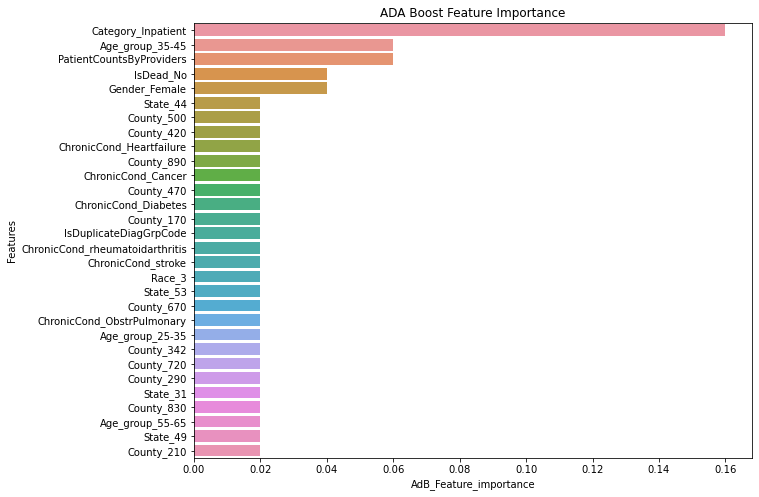

In [44]:
plt.figure(figsize=(10,8))
plt.title('ADA Boost Feature Importance')
FIM = FIM.sort_values(by=['AdB_Feature_importance'], ascending=False )
sns.barplot(y='Features', x='AdB_Feature_importance', data=FIM.head(30))
plt.show()

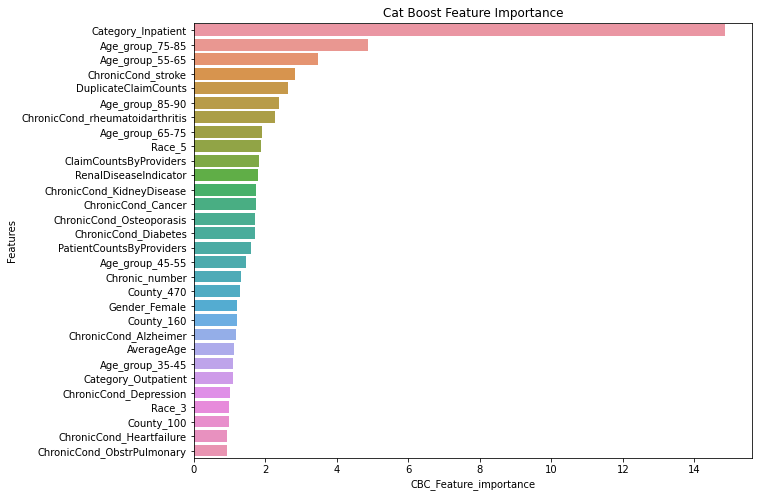

In [45]:
plt.figure(figsize=(10,8))
plt.title('Cat Boost Feature Importance')
FIM = FIM.sort_values(by=['CBC_Feature_importance'], ascending=False )
sns.barplot(y='Features', x='CBC_Feature_importance', data=FIM.head(30))
plt.show()

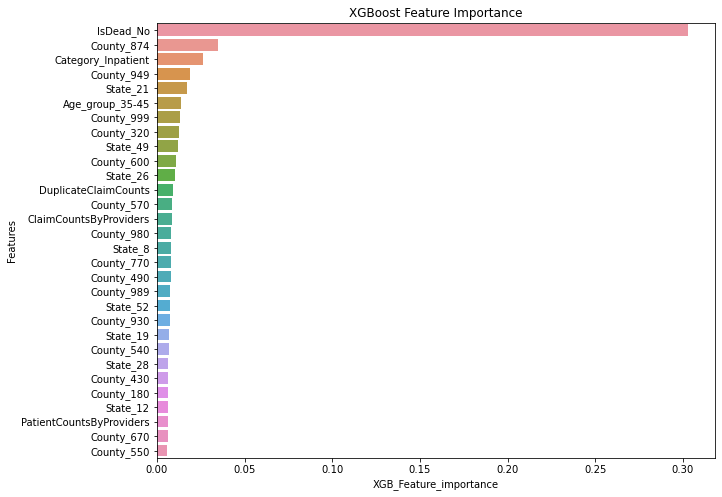

In [46]:
plt.figure(figsize=(10,8))
plt.title('XGBoost Feature Importance')
FIM = FIM.sort_values(by=['XGB_Feature_importance'], ascending=False )
sns.barplot(y='Features', x='XGB_Feature_importance', data=FIM.head(30))
plt.show()

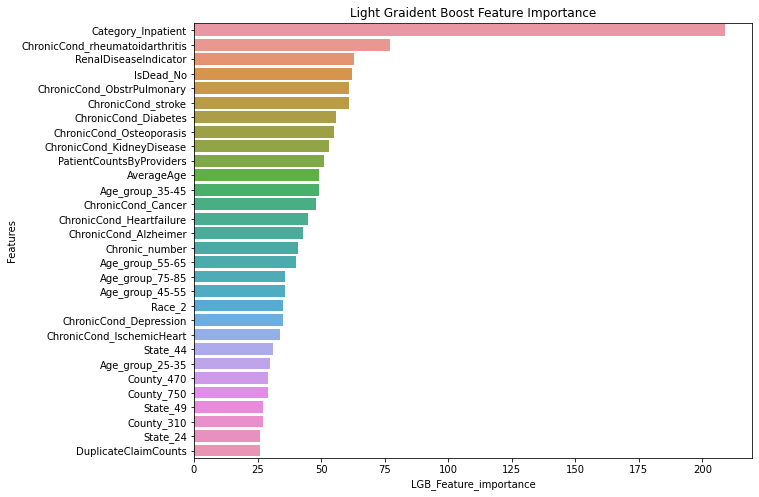

In [47]:
plt.figure(figsize=(10,8))
plt.title('Light Graident Boost Feature Importance')
FIM = FIM.sort_values(by=['LGB_Feature_importance'], ascending=False )
sns.barplot(y='Features', x='LGB_Feature_importance', data=FIM.head(30))
plt.show()

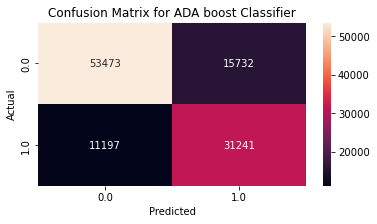

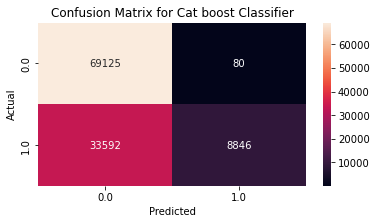

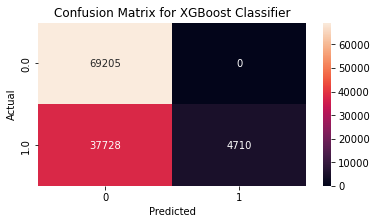

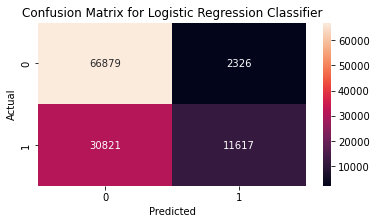

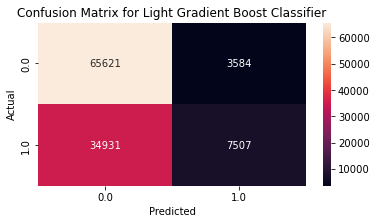

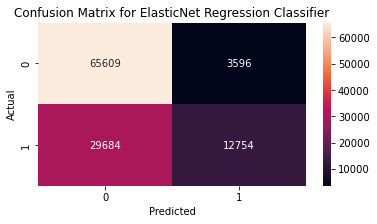

In [49]:
def confusionmatrix(y_actual, y_pred, modellabel=''):
    df=pd.DataFrame()
    df['Actual']=y_actual
    df['Predicted']=y_pred

    confusion_matrix = pd.crosstab(df['Actual'], df['Predicted'], rownames=['Actual'], colnames=['Predicted'])

    sns.heatmap(confusion_matrix, annot=True, fmt='g')

    plt.title('Confusion Matrix for ' +modellabel+' Classifier')
    plt.show()
    
confusionmatrix(test_y_ord, y_hat_AdB, modellabel='ADA boost')
confusionmatrix(test_y_ord, y_hat_CBC, modellabel='Cat boost')
confusionmatrix(test_y_ord, y_hat_XGB, modellabel='XGBoost')
confusionmatrix(test_yd, yd_hat_Logistic, modellabel='Logistic Regression')
confusionmatrix(test_y_ord, y_hat_GBM, modellabel='Light Gradient Boost')
confusionmatrix(test_yd, yd_hat_ElasticNet, modellabel='ElasticNet Regression')
